In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'figure.figsize': [10,10]})

Microsoft News Recommendation


* MINDsmall_train\behaviors.tsv
* MINDsmall_train\entity_embedding.vec
* MINDsmall_train\news.tsv
* MINDsmall_train\relation_embedding.vec
* news.tsv\news.tsv

Several important questions:
* What is the biggest difference between news recommendations and general product recommendations?
* News is also treated as a commodity, so do we also need to put the news ID?
* What should I do if the news is too long and exceeds the preset sequence length?


In [3]:
import time
import glob
import os
import math
import cv2
import builtins
import copy
import gc

os.environ['TRIDENT_BACKEND'] = 'pytorch'
os.environ['TRIDENT_HOME'] = './trident'

!pip uninstall tridentx -y
!pip install ../input/trident/tridentx-0.7.5-py3-none-any.whl --upgrade

#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.data.data_loaders import *

Found existing installation: tridentx 0.7.5
Uninstalling tridentx-0.7.5:
  Successfully uninstalled tridentx-0.7.5
Processing /kaggle/input/trident/tridentx-0.7.5-py3-none-any.whl


trident 0.7.5


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.11.0.
Automatic Mixed Precision Support:True.


Opencv version:4.5.4.
Pillow version:9.1.1.


In [4]:
import pandas as pd
df_news=pd.read_csv('../input/mind-news-dataset/news.tsv/news.tsv',header=None,sep='\t')
df_news.columns=['NewsID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"TitleEntities",
"AbstractEntities"]
#df_news.set_index(inplace=True)
df_news = df_news.fillna('')

def count_length(s):
    return len(s.split(' '))+2

df_news['abstract_length']=df_news['Abstract'].apply(count_length)
df_news['title_length']=df_news['Title'].apply(count_length)
df_news['total_text']=df_news['abstract_length']+df_news['title_length']+4
df_news

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities,abstract_length,title_length,total_text
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],14,13,31
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",21,8,33
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",38,14,56
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",23,14,41
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...",33,13,50
...,...,...,...,...,...,...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...",24,11,39
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[],3,12,19
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[],79,13,96
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[],14,8,26


In [5]:
category=df_news['Category'].unique()
subcategory=df_news['SubCategory'].unique()
print(category)
print(subcategory)
print(len(category))
print(len(subcategory))
category_mapping=OrderedDict()
subcategory_mapping=OrderedDict()
category_mapping['0']=0
subcategory_mapping['0']=0
for i, id in enumerate(category):
    category_mapping[id]=i+1
for i, id in enumerate(subcategory):
    subcategory_mapping[id]=i+1
    


['lifestyle' 'health' 'news' 'sports' 'weather' 'entertainment' 'autos'
 'travel' 'foodanddrink' 'tv' 'finance' 'movies' 'video' 'music' 'kids'
 'middleeast' 'northamerica']
['lifestyleroyals' 'weightloss' 'newsworld' 'voices' 'medical'
 'football_nfl' 'weathertopstories' 'gaming' 'newsscienceandtechnology'
 'nutrition' 'autosenthusiasts' 'wellness' 'health-news' 'celebrity'
 'travelarticle' 'autossuvs' 'newspolitics' 'traveltripideas' 'autosnews'
 'newsbusiness' 'golf' 'lifestylepetsanimals' 'recipes' 'tv-gallery'
 'basketball_nba' 'lifestylebuzz' 'shop-all' 'newsphotos'
 'basketball_ncaa' 'finance-real-estate' 'quickandeasy' 'tv-celebrity'
 'travelnews' 'movies-gallery' 'tipsandtricks' 'autosbuying' 'more_sports'
 'shop-apparel' 'autostrucks' 'lifestyledidyouknow' 'racing' 'newstrends'
 'restaurantsandnews' 'lifestylemindandsoul' 'baseball_mlb'
 'finance-saving-investing' 'viral' 'finance-taxes' 'lifestylebeauty'
 'newsopinion' 'finance-companies' 'lifestyleshopping' 'finance-savemon

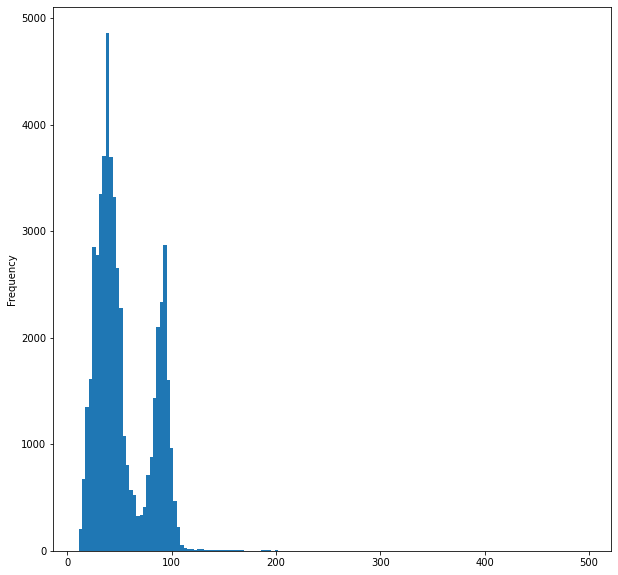

In [6]:
df_totaltext=df_news["total_text"]
ax = df_totaltext.plot.hist(bins=150)

In [8]:
#print(df_news.loc[0])
print(df_news.loc[0]['TitleEntities'])
#print(df_news.loc[0].Abstract )
#(df_news.loc[0]['Title Entities'])
print(eval(df_news.loc[0]['TitleEntities']).__class__.__name__)
print(eval(df_news.loc[0]['TitleEntities'])[0].__class__.__name__)

[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]
list
dict


Several ideas on how to do it:
* The pursuit of news is "new". The key is to push the news out. No one wants to read old news.
* Therefore, based on product ID, modeling based on past behavior is different. In news recommendations, historical news IDs will not be looked at, because this will be bound to old news.
* The key point is to find out the representation of news!! Then observe which type of news users are interested in.
* News representation = title representation + content summary representation + keyword representation + classification level representation + time heat representation
* The text representation mechanism should be dealt with independently first, and then the relationship between users and content should be dealt with
* How to incorporate the concept of internal classification? You can add classification subtasks

In [9]:
from transformers import BertTokenizer,BertModel,BertTokenizerFast
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained('bert-base-uncased').cuda()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:

enc = tokenizer.encode('Title:'+df_news.loc[0].Title+' Abstract:'+df_news.loc[0].Abstract)
dec = tokenizer.decode(enc)
print("text: " +'Title:'+df_news.loc[0].Title+' Abstract:'+df_news.loc[0].Abstract)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

text: Title:The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By Abstract:Shop the notebooks, jackets, and more that the royals can't live without.
Encode: [101, 2516, 1024, 1996, 9639, 3035, 3870, 1010, 3159, 2798, 1010, 1998, 3159, 5170, 8415, 2011, 10061, 1024, 4497, 1996, 14960, 2015, 1010, 17764, 1010, 1998, 2062, 2008, 1996, 15426, 2064, 1005, 1056, 2444, 2302, 1012, 102]
Decode: [CLS] title : the brands queen elizabeth, prince charles, and prince philip swear by abstract : shop the notebooks, jackets, and more that the royals can't live without. [SEP]


In [11]:
encoding = tokenizer.encode_plus(
  text='Title:'+df_news.loc[0].Title+' Abstract:'+df_news.loc[0].Abstract,
  max_length=128,           # max length of sentence 
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(encoding.keys())
print(encoding['input_ids'])
print(encoding['attention_mask'])

dict_keys(['input_ids', 'attention_mask'])
tensor([[  101,  2516,  1024,  1996,  9639,  3035,  3870,  1010,  3159,  2798,
          1010,  1998,  3159,  5170,  8415,  2011, 10061,  1024,  4497,  1996,
         14960,  2015,  1010, 17764,  1010,  1998,  2062,  2008,  1996, 15426,
          2064,  1005,  1056,  2444,  2302,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

In [12]:
output = bert_model(
  input_ids=encoding['input_ids'].to(get_device()),
  attention_mask=encoding['attention_mask'].to(get_device())
)

print(type(output))
print(output.keys())
print(encoding['input_ids'].shape)
print(output['last_hidden_state'].shape)
print(output['pooler_output'].shape)
print(output['last_hidden_state'])
print(output['pooler_output'])
print(bert_model.config.hidden_size)


#output['last_hidden_state'].shape為torch.Size([1, 128, 768])
#output['pooler_output'].shape為torch.Size([1, 768])


<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([1, 128])
torch.Size([1, 128, 768])
torch.Size([1, 768])
tensor([[[-0.2115, -0.0216,  0.0495,  ..., -0.7094,  0.1905,  0.4563],
         [-0.1241, -0.1431, -0.0270,  ..., -0.5321,  0.5526, -0.3633],
         [-0.0733,  1.0091, -0.1569,  ..., -0.3729,  0.1753, -0.2123],
         ...,
         [ 0.3092, -0.3058,  0.3448,  ...,  0.0343, -0.0934, -0.2106],
         [ 0.3239, -0.4040,  0.1580,  ...,  0.0724, -0.0598, -0.3434],
         [ 0.2291, -0.0945,  0.4730,  ..., -0.1100, -0.0781, -0.0689]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
tensor([[-0.7860, -0.5440, -0.9750,  0.7689,  0.8164, -0.0407,  0.7450,  0.3210,
         -0.8920, -1.0000, -0.6328,  0.9353,  0.9672,  0.7614,  0.8381, -0.4254,
          0.2377, -0.5353,  0.3808,  0.3539,  0.7028,  1.0000, -0.3252,  0.4195,
          0.6203,  0.9909, -0.6619,  0.8936,  0.928

In order to facilitate the subsequent modeling process, we do not need to query BERT again every time we train. We can query various embedded news in advance and then store them. Afterwards, the training process only needs to call the stored results. In order to avoid the GPU exploding, the generated embedded will be converted into numpy form.

In addition, Microsoft has also prepared pre-trained Entity Embedded that can be used directly.

In [13]:

entity_embedding = pd.read_table('../input/mind-news-dataset/MINDsmall_train/entity_embedding.vec', header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,'vector']].rename(columns={0: "entity"})
entity_embedding

,entity,vector
0,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
1,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
2,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
3,Q30,"[-0.115737, -0.179113, 0.102739, -0.112469, -0..."
4,Q60,"[-0.051036, -0.165637, 0.132802, -0.089949, -0..."
...,...,...
26899,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
26900,Q54860678,"[-0.03162, -0.041283, -0.016871, 0.044251, -0...."
26901,Q54860790,"[0.034682, -0.009413, -0.024317, 0.073895, 0.0..."
26902,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [14]:
entity_embedding_dict=OrderedDict()
for index, row in tqdm(entity_embedding.iterrows(), total=entity_embedding.shape[0]):
    entity_embedding_dict[row.entity]=np.array(row.vector)

100%|██████████| 26904/26904 [00:02<00:00, 12193.96it/s]


In [16]:
news_ids=df_news['NewsID'].unique()
print(news_ids[:5])


#0是padding
news_id_mapping=OrderedDict()
news_id_mapping['0']=0
for i, id in enumerate(news_ids):
    news_id_mapping[id]=i+1

print(len(news_id_mapping))

['N55528' 'N19639' 'N61837' 'N53526' 'N38324']
51283


Next we need to construct a dictionary structure, the key is the news id, and the value is:
> Title and abstract Embedded + entity Embedded + news category Embedded

In the original NAML model, multi-level feature vectors such as title, abstract, entity, large category, and medium category are required to be superimposed, and each uses different nlp technology, but these are relatively old feature extraction technologies. Ji Yan We now have a large language model, and we directly use Bert to help us extract features. We store these features after a single execution, so that we can save the labor resources of querying Bert.

In [17]:
import time

newsEmbeddings=OrderedDict() 
newsCategories=OrderedDict()
newsSubCategories=OrderedDict()

if os.path.exists('./newsEmbeddings1.pkl') and os.path.exists('./newsCategories.pkl')  and os.path.exists('./newsSubCategories.pkl') :
    newsEmbeddings=unpickle('./newsEmbeddings.pkl')
    newsCategories=unpickle('./newsCategories.pkl')
    newsSubCategories=unpickle('./newsSubCategories.pkl')

else:


    newsEmbeddings[0]=np.random.uniform(-0.002,0.002,(868))
    newsCategories[0]=0
    newsSubCategories[0]=0
    for i in tqdm(range(len(df_news))):
        newsEmbeddings[i+1]=None
        newsCategories[i+1]=None
        newsSubCategories[i+1]=None



    for index, row in tqdm(df_news.iterrows(), total=df_news.shape[0]):
        if index>0 and index%1000==0:
            time.sleep(0.002)


        #title_abstract
        encoding = tokenizer.encode_plus(
              text='Title:'+row.Title+' Abstract:'+row.Abstract,
              max_length=256,           # max length of sentence 
              add_special_tokens=True, # Add '[CLS]' and '[SEP]'
              return_token_type_ids=False,
              padding='max_length',
              truncation=True,
              return_attention_mask=True,
              return_tensors='pt',  # Return PyTorch tensors
            )
        output = bert_model(
          input_ids=encoding['input_ids'].to(get_device()),
          attention_mask=encoding['attention_mask'].to(get_device())
        )

    #     newsEmbeddings[row.NewsID]['title_abstract']=to_numpy(output['pooler_output'][0])
    #     newsEmbeddings[row.NewsID]['category']=row.Category
    #     newsEmbeddings[row.NewsID]['subcategory']=row.SubCategory
        
        t_entities=eval(row.TitleEntities) if len(row.TitleEntities.strip())>=2 else []
        a_entities=eval(row.AbstractEntities) if len(row.AbstractEntities.strip())>=2 else []
    #     try:

    #         temp_entities={}
    #         for item in t_entities:
    #             if len(item['SurfaceForms'])>0 and item['SurfaceForms'][0] not in temp_entities and item['Confidence']>0.75:
    #                 temp_entities[item['SurfaceForms'][0]]=item['Confidence']
    #         for item in a_entities:
    #             if len(item['SurfaceForms'])>0 and item['SurfaceForms'][0] not in temp_entities and item['Confidence']>0.75:
    #                 temp_entities[item['SurfaceForms'][0]]=item['Confidence']

    #        
    #         #title_abstract
    #         entity_encoding1 = tokenizer.encode_plus(
    #               text=','.join(list(temp_entities.keys())),
    #               max_length=256,           # max length of sentence 
    #               add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    #               return_token_type_ids=False,
    #               padding='max_length',
    #               truncation=True,
    #               return_attention_mask=True,
    #               return_tensors='pt',  # Return PyTorch tensors
    #             )
    #         entity_output1 = bert_model(
    #           input_ids=entity_encoding1['input_ids'].to(get_device()),
    #           attention_mask=encoding['attention_mask'].to(get_device())
    #         )

    #         newsEmbeddings[row.NewsID]['join_entities']=to_numpy(entity_output1['pooler_output'][0])

    #         mask=entity_encoding1['input_ids']>0
    #         newsEmbeddings[row.NewsID]['mean_entities']=to_numpy(entity_output1['last_hidden_state'][mask,:].mean(0))
    #     except:
    #         newsEmbeddings[row.NewsID]['join_entities']=np.zeros((768))
    #         newsEmbeddings[row.NewsID]['mean_entities']=np.zeros((768))
        ms_entities_embedded=None  
        try:

            temp_wiki_entities=OrderedDict()
            for item in t_entities:
                if item['WikidataId'] not in temp_wiki_entities and  item['WikidataId'] in entity_embedding_dict:
                    temp_wiki_entities[item['WikidataId']]=entity_embedding_dict[item['WikidataId']]
            for item in a_entities:
                if item['WikidataId'] not in temp_wiki_entities and item['WikidataId'] in entity_embedding_dict:
                    temp_wiki_entities[item['WikidataId']]=entity_embedding_dict[item['WikidataId']]
            
            ms_entities_embedded=np.stack(temp_wiki_entities.value_list(),0).mean(0)
        except:
           
            ms_entities_embedded=np.random.uniform(-0.002,0.002,(100))

        newsEmbeddings[news_id_mapping[row.NewsID]]=np.concatenate([to_numpy(output['pooler_output'][0]),ms_entities_embedded])
        newsCategories[news_id_mapping[row.NewsID]]=category_mapping[row.Category]
        newsSubCategories[news_id_mapping[row.NewsID]]=subcategory_mapping[row.SubCategory]
        if index<3:
            print(newsEmbeddings[news_id_mapping[row.NewsID]].shape)
    #     if index<1:
    #         print(encoding['input_ids'])
    #         break
    #         print(','.join(list(temp_entities.keys())))
    #         print(temp_entities)
    #         print(entity_encoding1['input_ids'])
    #         print(entity_output1['last_hidden_state'].shape)
    #         mask=entity_encoding1['input_ids']>0
    #         print(mask)

    #         print(entity_output1['last_hidden_state'][mask,:].mean(0).shape)






    print(len(newsEmbeddings))    
    pickle_it('./newsEmbeddings.pkl',newsEmbeddings)
    pickle_it('./newsCategories.pkl',newsCategories)
    pickle_it('./newsSubCategories.pkl',newsSubCategories)
    
    

  0%|          | 11/51282 [00:00<15:09, 56.35it/s]

(868,)
(868,)
(868,)


100%|██████████| 51282/51282 [12:24<00:00, 68.92it/s]


51283


In [19]:
# from transformers import AutoModelForMaskedLM,BertTokenizerFast
# tokenizer_zh = BertTokenizerFast.from_pretrained('bert-base-chinese')
# model_zh = BertModel.from_pretrained('ckiplab/bert-base-chinese') # or other models above


In [23]:
# encoding_zh = tokenizer_zh.encode_plus(
#   text='The weather is so nice today，It’s the beginning of autumn and it’s still very hot',
#   max_length=128,           # max length of sentence 
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   padding='max_length',
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
# )
# print(encoding_zh.keys())
# print(encoding_zh['input_ids'])
# print(encoding_zh['attention_mask'])

In [25]:
# output = model_zh(
#   input_ids=encoding_zh['input_ids'],
#   attention_mask=encoding_zh['attention_mask']
# )

# print(type(output))
# print(output.keys())
# print(encoding_zh['input_ids'].shape)
# print(output['last_hidden_state'].shape)
# print(output['pooler_output'].shape)
# print(output['last_hidden_state'])
# print(output['pooler_output'])
# print(model_zh.config.hidden_size)

## behaviors.tsv
The behaviors.tsv file contains exposure records and user news click history records. It has five data rows divided by index label symbols:

* Exposure identification code. The exposure identifier.
* User identification code. The user's anonymous identifier.
* time. Exposure time in the format "MM/DD/YYYY HH:MM:SS AM/PM".
* [Process Record]. A record of this user's news click history before this exposure (a list of identifiers for the clicked news).
* Exposure. A list of news items displayed in this exposure based on the user's click behavior (1 for clicks, 0 for no clicks).

In [26]:
df_behavior=pd.read_csv('../input/mind-news-dataset/MINDsmall_train/behaviors.tsv',header=None,sep='\t')
df_behavior.columns=['seq',
"userid", "imp_time", "history", "imps"]
df_behavior['imp_time'] = pd.to_datetime(df_behavior['imp_time'])
df_behavior = df_behavior.fillna('')
df_behavior

,seq,userid,imp_time,history,imps
0,1,U13740,2019-11-11 09:05:58,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,2019-11-12 18:11:30,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,2019-11-14 07:01:48,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,2019-11-11 05:28:05,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,2019-11-12 16:11:21,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...,...,...
156960,156961,U21593,2019-11-14 22:24:05,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,2019-11-13 06:57:04,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,2019-11-14 10:58:13,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,2019-11-13 14:57:02,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


In [27]:
user_ids=df_behavior['userid'].unique()
user_id_mapping = {id:i for i, id in enumerate(user_ids)}


In [28]:
df_U13740=df_behavior[df_behavior['userid']=='U13740']
df_U13740=df_U13740.sort_values(['imp_time'],ascending=False)

df_U13740

,seq,userid,imp_time,history,imps
154836,154837,U13740,2019-11-13 15:27:40,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N13907-0 N8509-0 N47061-0 N51048-0 N22417-0 N3...
0,1,U13740,2019-11-11 09:05:58,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
35262,35263,U13740,2019-11-09 05:59:43,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N20020-0 N3737-0 N43202-0 N18708-0 N30125-0 N3...


In [29]:
print(df_U13740.iloc[0].history)
print(df_U13740.iloc[1].history)
print(df_U13740.iloc[2].history)
print(df_U13740.iloc[0].imps)
print(df_U13740.iloc[1].imps)
print(df_U13740.iloc[2].imps)

N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801
N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801
N55189 N42782 N34694 N45794 N18445 N63302 N10414 N19347 N31801
N13907-0 N8509-0 N47061-0 N51048-0 N22417-0 N35273-0 N33831-0 N64252-0 N18862-0 N58133-1 N56214-0 N37437-0 N38215-0 N4510-0 N14029-0 N17117-0 N51287-0 N24767-0 N21420-0 N41612-0 N62894-0 N34048-0 N36261-0 N36016-0 N21128-0 N4642-0
N55689-1 N35729-0
N20020-0 N3737-0 N43202-0 N18708-0 N30125-0 N349-0 N43388-0 N32260-0 N3491-0 N57972-0 N43370-0 N31602-0 N7128-0 N43001-0 N10359-0 N22600-0 N10602-0 N5889-0 N17650-0 N59761-0 N7891-0 N31025-0 N49879-0 N31748-0 N59457-0 N60374-0 N38330-0 N46567-0 N33291-0 N58075-0 N52649-0 N54300-0 N39707-0 N1080-0 N21428-0 N15361-0 N59931-0 N41400-0 N39115-0 N59893-0 N14522-0 N3449-0 N28091-0 N5442-0 N63835-0 N20147-0 N23060-0 N19099-0 N39587-0 N14884-0 N29749-0 N33981-0 N17087-0 N62647-0 N9019-0 N53343-0 N64228-0 N41615-0 N52875-0 N60186-0 N62801-0 N18378-0 N49953-0 N59143

In [30]:
userid_history = {}
sessions = []
history_window_size=50


for index, line in tqdm(df_behavior.iterrows(), total=df_behavior.shape[0]):

    histories = [news_id_mapping[newsid] for newsid in line.history.split(" ") if newsid in news_id_mapping]
    #歷史數據要取定長(history_window_size)，用零補滿
    histories = [0]*(history_window_size - len(histories)) + histories[: history_window_size]
    
    pos = []
    neg = []
    imps = line.imps.split(" ")
    impr_news = [news_id_mapping[i.split("-")[0]] for i in imps]
    user_index=user_id_mapping[line.userid]
    for imp in imps:
        if imp.split("-")[1] == "1":
            pos.append(news_id_mapping[imp.split("-")[0]])
        else:
            neg.append(news_id_mapping[imp.split("-")[0]])
    userid_history[user_index] = histories
    sessions.append([user_index,histories, pos, neg])
print(len(userid_history))
print(len(sessions))
print(sessions[1])

pickle_it('./sessions.pkl',sessions)
pickle_it('./userid_history.pkl',userid_history)

100%|██████████| 156965/156965 [00:30<00:00, 5163.90it/s]


50000
156965
[1, [25816, 2334, 8524, 12087, 13463, 14202, 12733, 26998, 22954, 21717, 28044, 2394, 28920, 23107, 17164, 15871, 25725, 28192, 29418, 17080, 28646, 28583, 17680, 30635, 14857, 8178, 2757, 4501, 2600, 26144, 22037, 4853, 10970, 129, 19188, 5642, 25937, 22638, 10693, 27868, 13919, 13995, 1082, 26638, 25906, 20529, 6875, 28125, 1537, 29991], [32187], [37405, 41306, 34907, 35307, 44370, 37210, 43907, 43357, 43694, 45366]]


In [31]:
def _newsample(nnn, ratio=3.5):
    if ratio > len(nnn):
        return random.sample(nnn * (ratio // len(nnn) + 1), ratio)
    else:
        return random.sample(nnn, ratio)



users=[]
histories=[]
news_candidates=[]
clicks=[]
for sess_id in tqdm(range(len(sessions))):
    sess = sessions[sess_id]
  
    user_index, history, poss, negs = sess
    for i in range(len(poss)):
        pos = poss[i]
        neg = _newsample(negs, 4)
        clicks.append(1)
        users.append(user_index)
        histories.append(history)
        news_candidates.append(pos)
        
        for neg_ins in neg:
            clicks.append(0)
            users.append(user_index)
            histories.append(history)
            news_candidates.append(neg_ins)

print(len(news_candidates))

100%|██████████| 156965/156965 [00:03<00:00, 50211.93it/s]

1181720


TimeDistributed contains a neural network layer module. The function of TimeDistributed is to operate the module one by one on the time slices of the input data.
For example, the shape of the input user browsing history data is (16,50,100). 16 is the number of batches, which means that it contains 16 user data. Each user is based on the time window length of 50 (any shortcomings are filled with zeros), and the last 100 is Feature vector length of browsed news. If this tensor is input to TimeDistributed, it will be sliced ​​along time (if batch_first=False is set, the time slice is on the 0th axis, if batch_first=True is set, the time slice is on the 1st axis, so it must be processed first Go to axis 0)

### NAML model(Neural News Recommendation with Attentive Multi-View Learning)

    Chuhan Wu, Fangzhao Wu, Mingxiao An, Jianqiang Huang, Yongfeng Huang and Xing Xie,
    Neural News Recommendation with Attentive Multi-View Learning, IJCAI 2019

## Construct NAML model
It encodes news through NewsEncoder (here, Bert is used to obtain features to simplify the more complex and low-level process of the original version), so that when new news appears, there is no need to remodel the model, and there is no need to change the model structure. In addition, it uses UserEncoder to shape the user's representation based on the news that the user has clicked in the past, instead of using User_Index directly. Both mechanisms make feature caching possible. Then we can input the candidate news to obtain its representation, as well as the representation shaped by a user's historical browsing behavior. After multiplying the matrix, the final output is a sigmoid to predict whether the user will buy such a combination.

The following are two new neural layers, responsible for time slice processing and attention mechanism respectively.

In [32]:
class TimeDistributed(Layer):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        #print('TimeDistributed',x.shape)
        if len(x.size()) <= 2:
            return self.module(x)

        # Time slicing merged with batch axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (batch axis * time slice, input vector)
        #print('TimeDistributed',x_reshape.shape)
        y = self.module(x_reshape)
        #print('TimeDistributed',y.shape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (batch axis, time slice, Output vector)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (time slice, batch axis, Output vector)
        #print('TimeDistributed',y.shape)
        return y
    
    
class Attention(Layer):
    def __init__(self, dim=200):
        super(Attention, self).__init__()
        self.dim = dim
    def build(self, input_shape: TensorShape):
        if not self._built:

            self.register_parameter('w' ,Parameter(torch.Tensor(int(input_shape[-1]),self.dim).to(get_device())))
            self.register_parameter('b' ,Parameter(torch.Tensor( self.dim ,).to(get_device())))
            self.register_parameter('q' ,Parameter(torch.Tensor( self.dim,1).to(get_device())))
    def forward(self, x ,mask=None):
        att = torch.tanh(torch.matmul(expand_dims(x,1), self.w)+ self.b)  # [batch, seq_len, hidden_dim*2]
        att = torch.matmul(att, self.q)  # [batch, seq_len, 1]
        att =squeeze(att, axis=1)


        if mask is None:
            att = exp(att)
        else:
            att = exp(att) * mask.float()

        attention_weight = att / (reduce_sum(att, axis=-1, keepdims=True) + 1e-5)
        #attention_weight = expand_dims(attention_weight)
        weighted_input = x * attention_weight
#         if len(weighted_input.shape)==3:
#             weighted_input=reduce_sum(weighted_input,axis=1)
        return weighted_input

 


## NewsEncoder
The input is a news integer index, query the pre-cached Bert representation (length 868), and query the large classification and medium classification of the news to generate large classification and medium classification representations (length 100 each), superimpose the feature vectors (length 1068) and then reduced the dimensionality to 400, while improving the versatility and attention mechanism through Dropout.

In [33]:
class NewsEncoder(Layer):
    def __init__(self,newsEmbeddings,newsCategories,newsSubCategories):
        super(NewsEncoder, self).__init__()
        #print('len(news_id_mapping)',len(news_id_mapping))
        #print('len(newsEmbeddings)',len(newsEmbeddings))
        self.newsEmbeddings=Embedding(num_embeddings=len(news_id_mapping),embedding_dim=868)
        self.newsCategories=Embedding(num_embeddings=len(news_id_mapping),embedding_dim=1)
        self.newsSubCategories=Embedding(num_embeddings=len(news_id_mapping),embedding_dim=1)
        
        
        self.category_encoder=Embedding(num_embeddings=len(category_mapping),embedding_dim=100)
        self.subcategory_encoder=Embedding(num_embeddings=len(subcategory_mapping)+1,embedding_dim=100)
        self.drop=Dropout(0.2)
        self.fc=Dense(num_filters=400)
        self.att=Attention(400)
        print('category_mapping',len(category_mapping))
        print('subcategory_mapping',len(subcategory_mapping))
        print(self.newsEmbeddings.weight.shape,np.stack(list(newsEmbeddings.values()),0).shape)
        
        self.newsEmbeddings.weight.data.copy_(to_tensor(np.stack(list(newsEmbeddings.values()),0)))
        self.newsCategories.weight.data.copy_(to_tensor(np.stack(list(newsCategories.values()),0)).unsqueeze(-1))
        self.newsSubCategories.weight.data.copy_(to_tensor(np.stack(list(newsSubCategories.values()),0)).unsqueeze(-1))
        self.newsEmbeddings.trainable=False
        self.newsCategories.trainable=False
        self.newsSubCategories.trainable=False
        
  
    def forward(self,newsids):
        #print('newsids.shape',newsids.shape)
        all_features=[]
        
        #Look up text tensor based on news index
        news_features=self.newsEmbeddings(newsids).squeeze()
        #Look up the large and medium classifications of news based on the news index
        category=self.newsCategories(newsids)
        subcategory=self.newsSubCategories(newsids)
        #print(category.shape,subcategory.shape)

        #Large classification and medium classification index lookup table shows the large classification and medium classification obtained through training
        category=self.category_encoder(category).squeeze()
        subcategory=self.subcategory_encoder(subcategory).squeeze()
       
        #Overlay features
        all_features=concate([news_features,category,subcategory],axis=-1)


        if self.training:
            all_features=self.drop(all_features)
        #Dimensionality reduction to 400
        all_features=self.fc(all_features)
        #print(all_features.shape)
        #Handle attention
        all_features=self.att(all_features)
        #print(all_features.shape)
        return all_features

    


## UserEncoder


In [34]:
class UserEncoder(Layer):
    def __init__(self,news_encoder):
        super(UserEncoder, self).__init__()
        self.news_encoder=news_encoder
        self.layer1=TimeDistributed(module=Dense(num_filters=400, activation='relu'))
      
        self.drop=Dropout(0.2)
        self.att=Attention(400)
        
       
    
    def forward(self,user_history): #[batch, history window] integer index tensor
        user_features=self.news_encoder(user_history)
        #[batch, history window,400]
        #print('user_features',user_features.shape,user_features)
        #print('user_features',user_features.shape)
        user_features=self.layer1(user_features)
        #print('user_features',user_features.shape,user_features)
        #[batch, history window,400]
        #print('user_features',user_features.shape)
        if self.training:
            user_features=self.drop(user_features)
        user_features=self.att(user_features)
        #print('user_features',user_features.shape,user_features)
        user_features=user_features.mean(1)
        #print('user_features',user_features.shape,user_features)
        #[batch, 400]
        return user_features

In [35]:
class NAML(Layer):
    def __init__(self):
        super(NAML, self).__init__()
        self.news_encoder = NewsEncoder(newsEmbeddings,newsCategories,newsSubCategories)
        self.user_encoder =UserEncoder(self.news_encoder)
        
        self.classifier =Dense(1)
        self.fc =Dense(64,activation='leaky_relu')
        self.norm =LayerNorm()
        self.sigmoid = Sigmoid()

    def forward(self, candidates, histories):
        #print(candidates, histories)
        #print('candidates',np.abs(to_numpy(candidates)).mean(),'histories',np.abs(to_numpy(histories)).mean())
        user_present = l2_normalize(self.user_encoder(histories),-1)
        #print('user_present',np.abs(to_numpy(user_present)).mean())
        news_present = l2_normalize(self.news_encoder(candidates),-1)
        #print('news_present',np.abs(to_numpy(news_present)).mean())
    
        preds=torch.bmm(news_present.unsqueeze(-1), user_present.unsqueeze(1)).mean(1)
        #print('preds_bmm',np.abs(to_numpy(preds)).mean())
        preds=self.fc(preds)
        preds=self.norm(preds)
        #print('preds',np.abs(to_numpy(preds)).mean())
        preds=self.classifier(preds)
        preds=preds.squeeze()
        #print('preds',np.abs(to_numpy(preds)).mean())
        preds = self.sigmoid(preds)
        #print('preds',np.abs(to_numpy(preds)).mean())
        return preds
    
# t1=zeros((32)).long()    #candidate_news_feature
# t2=zeros((32,50)).long() 

# _=net(t1,t2)

In [36]:
ds1=NumpyDataset(np.expand_dims(np.array(news_candidates).astype(np.int64),-1),symbol='candidates')
ds2=NumpyDataset(np.stack(histories,0).astype(np.int64),symbol='histories')
ds3=LabelDataset(clicks,symbol='clicks')

zipdataset=ZipDataset(ds1,ds2)
data_provider=DataProvider(traindata=Iterator(data=zipdataset,label=ds3))
print(data_provider.signature)

data_provider( ) -> candidates: Tensor[(None, 1)] (ObjectType.array_data), histories: Tensor[(None, 50)] (ObjectType.array_data), clicks: Tensor[(None, 1)] (ObjectType.regression_label) 


In [37]:
#usenext()Call data and check data
_candidates,_histories,_clicks=data_provider.next()
print(_candidates.shape,_histories.shape,_clicks.shape)
print(_candidates)
print(_histories)
print(_clicks)

(8, 1) (8, 50) (8,)
[[38537]
 [39635]
 [48160]
 [ 3200]
 [44899]
 [49429]
 [31635]
 [33175]]
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0  1061  7137   733 31859   812  6499 21347  1569
  19858 31331 16944 20301 16520 14217 17991 25093  9465 22327 23436 13759
  48410 41345]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0  4749 10314 16478 22790 20475 21142  9340 19983 25740 30299 25874
  24719 36976]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0 12380 29199   640  2394 20266  2088 1

In [38]:
net=Model(inputs=(_candidates,_histories),output=NAML())
#Weight initialization
xavier_normal(net.model,0.2)
net.summary()

category_mapping 18
subcategory_mapping 265
torch.Size([51283, 868]) (51283, 868)
44513644 parameters have set untrainable
51283 parameters have set untrainable
51283 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
                    Layer (type)                     Output Shape               Weight                      Bias      Param #   FLOPS #                  
news_encoder.newsEmbeddings  [Embedding]             (1, 50, 868)               'weight', [51283, 868]                44,513,644  77,275,685,116  
news_encoder.newsEmbeddings_1  [Embedding]           (1, 50, 868)               'weight', [51283, 868]                44,513,644  77,275,685,116  
news_encoder.newsCategories  [Embedding]             (1, 50, 1)                 'weight', [51283, 1]                  51,283  102,565  
news_encoder.newsCategories_1  [Embedding]           (1, 50, 1)                 'weight'

Model()

In [39]:
#Bundlefocal lossAdd to binary cross entropy loss middle
def bce_loss(output,clicks):
    #print('output',output,'clicks',clicks)
    output = clip(output, 1e-7, 1 - 1e-7)
    weight=where(clicks>0.5,ones_like(clicks)*4,ones_like(clicks))
    bce = ((1-output)**2.5)*clicks * torch.log(output)*weight
    bce +=  ((1-(1 - output))**2.5)*(1 - clicks) * torch.log(1 - output)*weight
    return -bce.sum()+8*((output-clicks.float())**2).mean()
    
def accuracy1(output,clicks):
    output = clip(output, 1e-7, 1 - 1e-7).squeeze()
    clicks=clicks.float().detach()
    return (greater(output,0.5)*clicks).sum()/clip(greater(output,0.5).sum(),min=1)

def recall1(output,clicks):
    output = clip(output, 1e-7, 1 - 1e-7).squeeze()
    clicks=clicks.float().detach()
    return (greater(output,0.5)*clicks).sum()/clip(clicks.sum(),min=1)
    

net.with_optimizer(optimizer=DiffGrad,lr=2e-4,betas=(0.9, 0.999),gradient_centralization='all',weight_decay=0.01)\
    .with_loss(bce_loss,loss_weight=1)\
    .with_metric(accuracy1,name='accuracy')\
    .with_metric(recall1,name='recall')\
    .with_learning_rate_scheduler(CosineLR(period=5000,unit='batch',max_lr=5e-4, min_lr=1e-5))\
    .with_model_save_path('Models/net.pth')\


bce_loss( output: Tensor[None] , clicks: Tensor[None] ) ->  
accuracy( output: Tensor[None] , clicks: Tensor[None] ) ->  
recall( output: Tensor[None] , clicks: Tensor[None] ) ->  


Model(
  (_losses): <function bce_loss at 0x7ba774cc73b0>
  (_metrics): <function accuracy1 at 0x7ba774cc8290>
  (_metrics): <function recall1 at 0x7ba940ea5f80>
  (loss_weights): 1.0
)

In [40]:
plan=TrainingPlan()\
    .add_training_item(net)\
    .with_data_loader(data_provider)\
    .repeat_epochs(3)\
    .with_batch_size(128)\
    .print_progress_scheduling(10,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=200,unit='batch',imshow=True)\
    .out_sample_evaluation_scheduling(frequency=200,unit='batch')\
    .save_model_scheduling(50,unit='batch')\

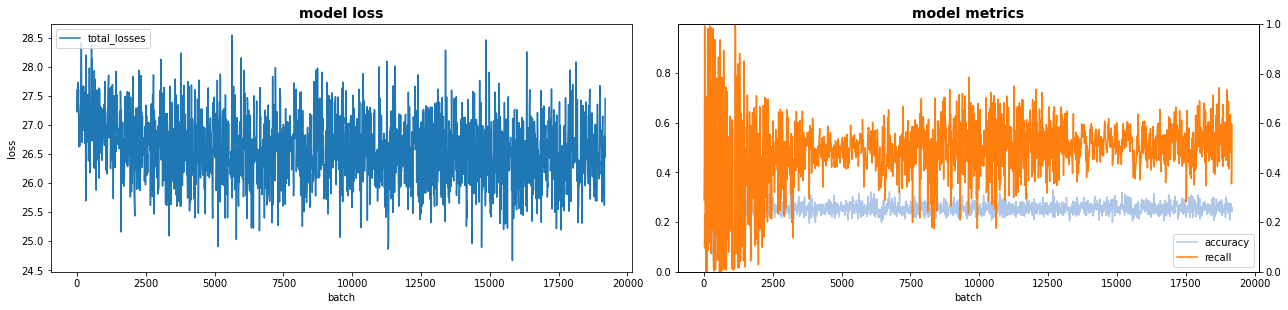

model 0  Step: 754ms    | Loss: 26.268 | accuracy: 24.361% , recall: 60.371%  | lr: 1.180e-04  | epoch: 2  ( 740/9233 )
model 0  Step: 688ms    | Loss: 26.101 | accuracy: 24.902% , recall: 46.121%  | lr: 1.181e-04  | epoch: 2  ( 750/9233 )
model 0  Step: 656ms    | Loss: 25.920 | accuracy: 24.358% , recall: 39.058%  | lr: 1.183e-04  | epoch: 2  ( 760/9233 )
model 0  Step: 661ms    | Loss: 26.124 | accuracy: 26.357% , recall: 47.655%  | lr: 1.185e-04  | epoch: 2  ( 770/9233 )
model 0  Step: 659ms    | Loss: 26.156 | accuracy: 23.438% , recall: 41.505%  | lr: 1.186e-04  | epoch: 2  ( 780/9233 )
model 0  Step: 663ms    | Loss: 26.382 | accuracy: 26.442% , recall: 51.295%  | lr: 1.188e-04  | epoch: 2  ( 790/9233 )
model 0  Step: 657ms    | Loss: 27.030 | accuracy: 27.976% , recall: 58.903%  | lr: 1.190e-04  | epoch: 2  ( 800/9233 )
model 0 out-of-sample evaluation: accuracy: 15.789%,recall: 31.579%
model 0  Step: 665ms    | Loss: 25.973 | accuracy: 27.714% , recall: 43.670%  | lr: 1.191e-0

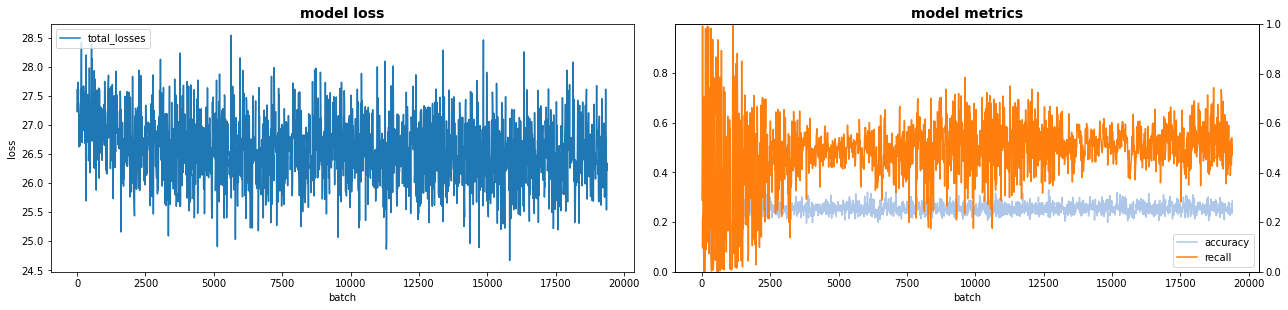

model 0  Step: 732ms    | Loss: 26.198 | accuracy: 25.645% , recall: 45.914%  | lr: 1.210e-04  | epoch: 2  ( 940/9233 )
model 0  Step: 658ms    | Loss: 26.874 | accuracy: 25.211% , recall: 52.669%  | lr: 1.211e-04  | epoch: 2  ( 950/9233 )
model 0  Step: 659ms    | Loss: 26.234 | accuracy: 25.341% , recall: 49.465%  | lr: 1.213e-04  | epoch: 2  ( 960/9233 )
model 0  Step: 654ms    | Loss: 26.830 | accuracy: 27.113% , recall: 46.994%  | lr: 1.214e-04  | epoch: 2  ( 970/9233 )
model 0  Step: 662ms    | Loss: 26.433 | accuracy: 24.966% , recall: 47.992%  | lr: 1.215e-04  | epoch: 2  ( 980/9233 )
model 0  Step: 661ms    | Loss: 25.926 | accuracy: 26.785% , recall: 55.442%  | lr: 1.216e-04  | epoch: 2  ( 990/9233 )
model 0  Step: 660ms    | Loss: 26.599 | accuracy: 24.960% , recall: 52.334%  | lr: 1.218e-04  | epoch: 2  ( 1000/9233 )
model 0 out-of-sample evaluation: accuracy: 35.714%,recall: 42.857%
model 0  Step: 660ms    | Loss: 26.714 | accuracy: 29.921% , recall: 51.542%  | lr: 1.219e-

In [ ]:
plan.start_now()